To do:
- comment/mark down
- reformatfigures into 2x1 
- check that the non nan values nearest x0 and y0 value are actually close to the values
- to change to magnitude multiply by time 
- can try if there is a valid value take the terminus/centereline intersection value and then if not what if you go up steam the centreline until there is a valid point 

In [1]:

#loading in dependencies, run this on greenlandMapping - future make new env
%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
import glob
import shapely
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

In [2]:
#paths
centreline_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/flowlines/glacier0001_iter03.shp"
terminus_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0781/collated/JakbobshavnIsbraeTerminus.shp"
velocity_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0766/JakobshavnIsbraeVelocitySeriesNew.nc"
centreline_maqit_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/centreline1.csv"

#read in velocity 
velocity = xr.open_dataset(velocity_path)

#read in centreline + make sure coordinate system = EPSG:3413
centreline = gpd.read_file(centreline_path)
centreline = centreline.to_crs("EPSG:3413")

#sanity check for geospatial alignment
print(centreline.crs)

centreline_shape = centreline.geometry.iloc[0]

#read in terminus
terminus = gpd.read_file(terminus_path)
terminus = terminus.to_crs("EPSG:3413")

#sanity check for geospatial alignment
print(terminus.crs)

terminus = terminus.rename(columns={"SourceDate": "Date"}) #rename for simplicity
terminus["Date"] = pd.to_datetime(terminus["Date"]) #make sure it is in datetime 
terminus = terminus.sort_values("Date").reset_index(drop=True) #sort in chronological 

EPSG:3413
EPSG:3413


In [3]:
x_vals = velocity["x"].values
y_vals = velocity["y"].values

vel_band = velocity["VelocityMap"].isel(band=2).assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)
vel_times = pd.to_datetime(vel_band["time"].values)


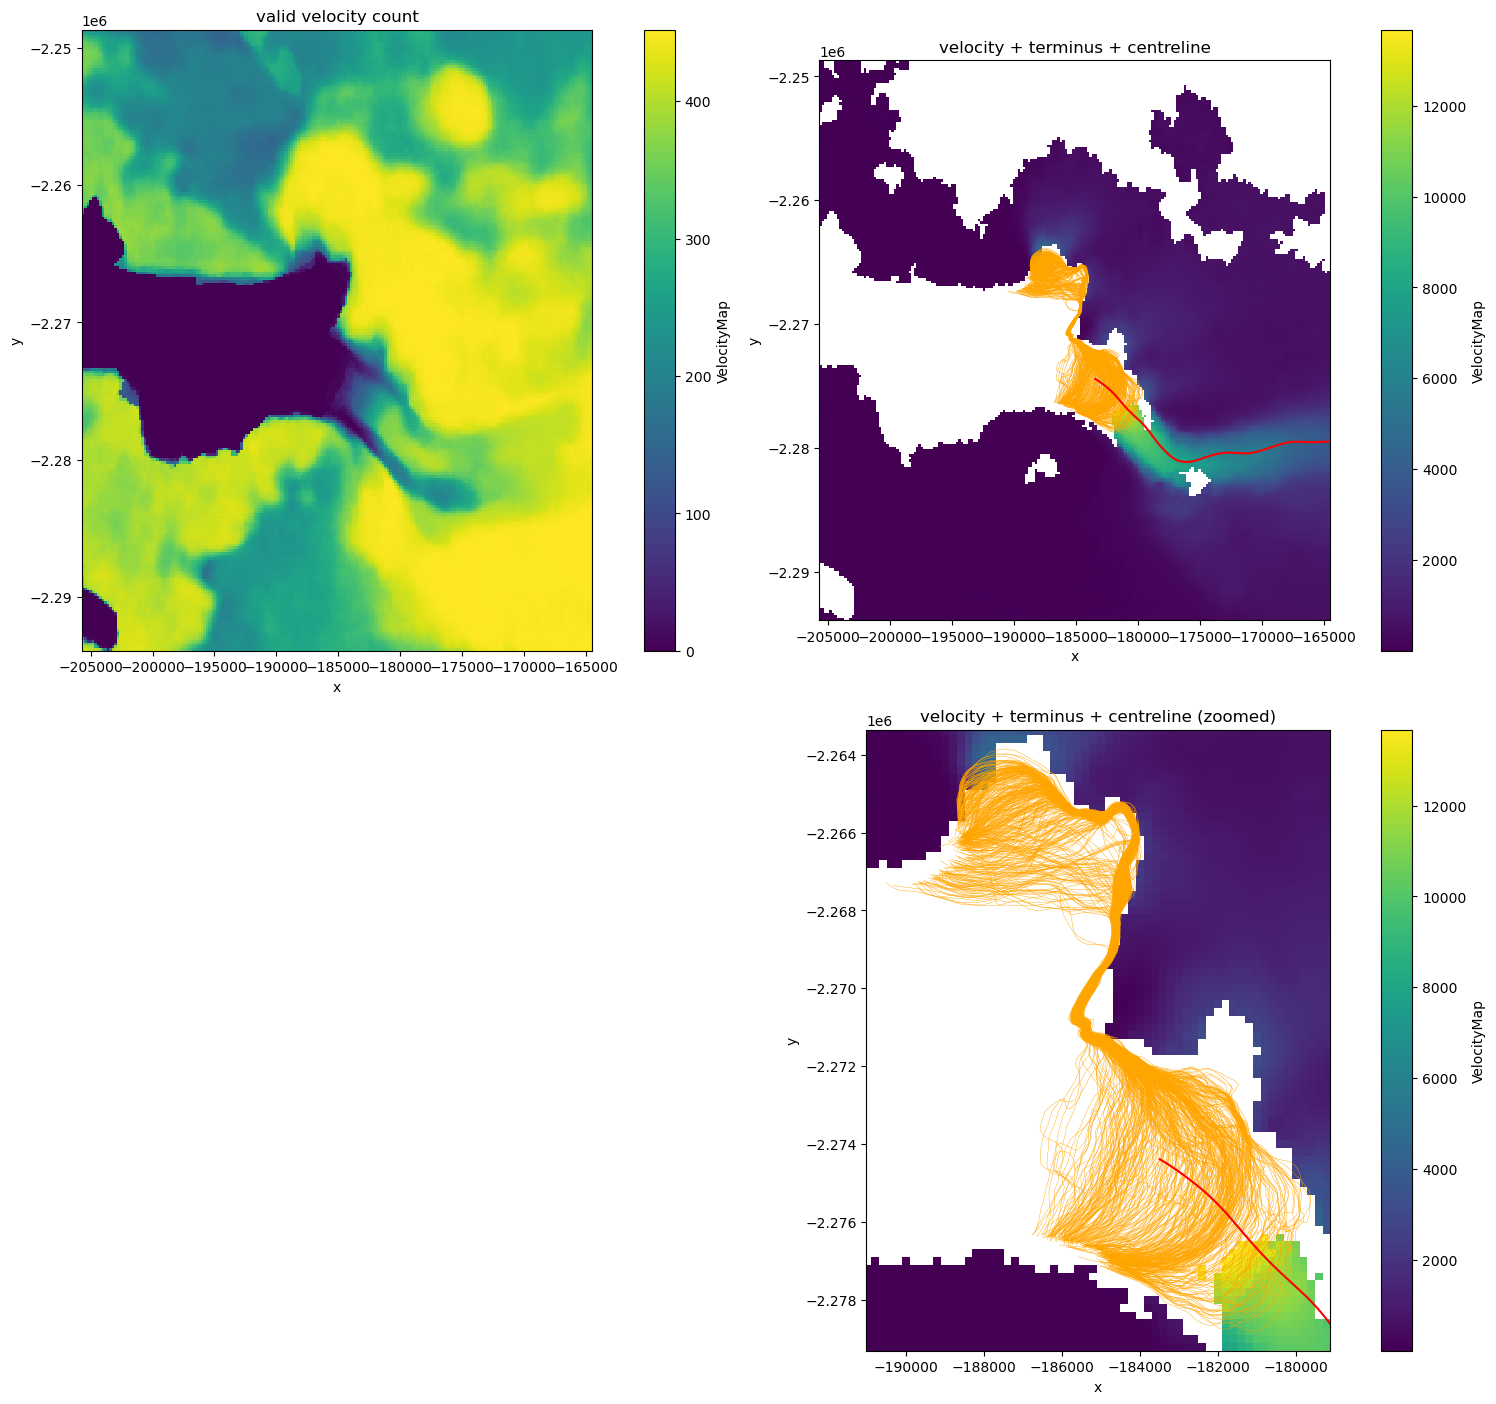

In [5]:
#plotting valid velocity values AND terminus (set)
    #yellow is has more, purple has less 
valid_count = vel_band.count(dim="time")  #points with "valid" non NaN values

nrow, ncol = (2, 2)

fig, ax = plt.subplots(
    figsize=(15, 15),
    layout ='compressed',
    nrows = nrow, 
    ncols = ncol,
) 

valid_count.plot(
    ax=ax[0,0],
    x="x",
    y="y",
    add_colorbar=True,
)
ax[0,0].set_title("valid velocity count")

#velocity visual w centerline and terminus 
sampletime = 300
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

vel_slice.plot(
    ax=ax[0,1],
    x="x",         
    y="y",         
    add_colorbar=True,
)

terminus.plot(
    ax=ax[0,1],
    facecolor="none",
    edgecolor="orange",
    linewidth=0.3,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax[0,1],
    color="red",
    linewidth=1.5,
)

ax[0,1].set_title("velocity + terminus + centreline")

#zoomed 
vel_slice.plot(
    ax=ax[1,1],
    x="x",         
    y="y",         
    add_colorbar=True,
)

terminus.plot(
    ax=ax[1,1],
    facecolor="none",
    edgecolor="orange",
    linewidth=0.3,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax[1,1],
    color="red",
    linewidth=1.5,
)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds
z00m = 500  

ax[1,1].set_xlim(xmin - z00m, xmax + z00m)
ax[1,1].set_ylim(ymin - z00m, ymax + z00m)

ax[1,1].set_title("velocity + terminus + centreline (zoomed)")

ax[1,0].axis("off")


plt.show()

velocity: 2017-09-25 12:00:00
terminus: 2017-09-25 00:00:00
velocity: 2020-10-21 12:00:00
terminus: 2020-10-21 00:00:00


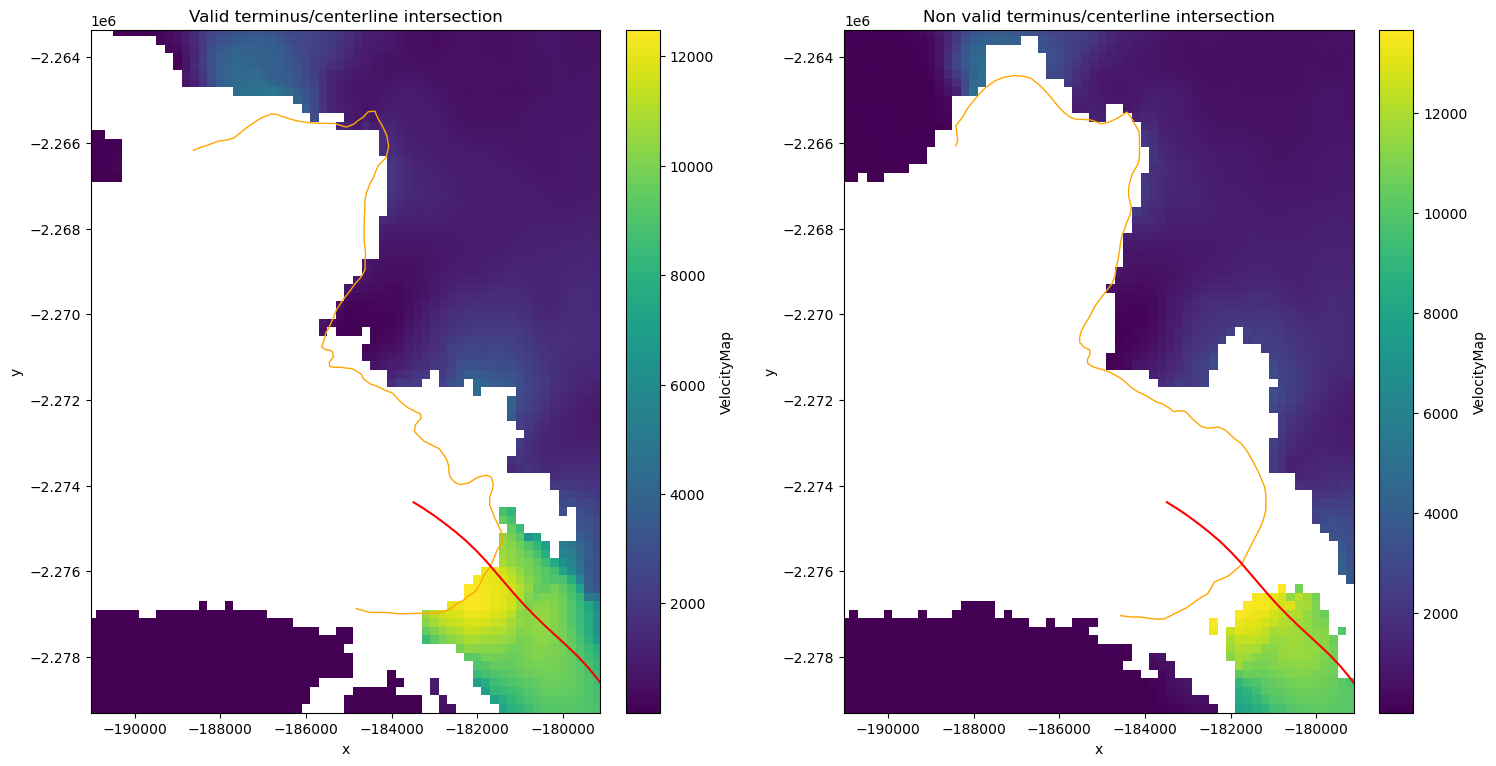

In [7]:
#visualising velocity, terminus and centerline on one with a VALID intersection value
    #velocity: 2017-10-01 12:00:00
    #terminus: 2017-10-01 00:00:00  
sampletime1 = 113

vel_time = velocity["time"].isel(time=sampletime1).values 
nearest_time = (terminus["Date"]- vel_time).abs().idxmin() #calc nearest terminus(Date) and vel time
term_time = terminus.loc[[nearest_time]] #this selects the terminus geometry from the nearest_time

vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime1)

#CHECK:are these the same day/near?
t_vel = pd.to_datetime(vel_time)
t_term = term_time["Date"].iloc[0]
print("velocity:", t_vel)
print("terminus:", t_term)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)
nrow, ncol = (1, 2)

fig, ax = plt.subplots(
    figsize=(15, 15),
    layout ='compressed',
    nrows = nrow, 
    ncols = ncol,
) 

vel_slice.plot(
    ax=ax[0],
    x="x",         
    y="y",         
    add_colorbar=True,
)

term_time.plot(
    ax=ax[0],
    facecolor="none",
    edgecolor="orange",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax[0],
    color="red",
    linewidth=1.5,
)

#visualising velocity, terminus and centerline on one with a NON VALID intersection value
sampletime2 = 300

vel_time = velocity["time"].isel(time=sampletime2).values 
nearest_time = (terminus["Date"]- vel_time).abs().idxmin() #calc nearest terminus(Date) and vel time
term_time = terminus.loc[[nearest_time]] #this selects the terminus geometry from the nearest_time

vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime2)

#CHECK:are these the same day/near?
t_vel = pd.to_datetime(vel_time)
t_term = term_time["Date"].iloc[0]
print("velocity:", t_vel)
print("terminus:", t_term)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

vel_slice.plot(
    ax=ax[1],
    x="x",         
    y="y",         
    add_colorbar=True,
)

term_time.plot(
    ax=ax[1],
    facecolor="none",
    edgecolor="orange",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax[1],
    color="red",
    linewidth=1.5,
)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

for a in ax:
    a.set_xlim(xmin - z00m, xmax + z00m)
    a.set_ylim(ymin - z00m, ymax + z00m)

ax[0].set_title("Valid terminus/centerline intersection")
ax[1].set_title("Non valid terminus/centerline intersection")

plt.tight_layout
plt.show()

finding the intersection between the centerline and the terminus 
- this will then be used to sample velocity values at that point
- originally (w/o buffer) there are 111 NaN values out of 357 

In [8]:

# finding the intersection between the centerline and the terminus
def intersection(centreline, terminus_line):
    intersect = centreline.intersection(terminus_line)

    if intersect.is_empty:
        return None
    
    if intersect.geom_type == "MultiPoint": #if there is more than one intersect put the point closes to the centre of the terminus line
        return min(intersect.geoms, key = lambda p: p.distance(terminus_line.centroid))
    
    return intersect
 
pts = []
for i in range(len(terminus)):
    terminus_line = terminus.geometry.iloc[i]
    pt = intersection(centreline_shape, terminus_line) #geometric intersection between centerline_shape and terminus_line 
    pts.append(pt)

terminus["intersect_points"] = pts

#check to see how many are None
none_vals = terminus["intersect_points"].isna().sum()
print(none_vals)

total = len(terminus["intersect_points"])
print(total)

#originally there were 111 Nan out of 357

111
357


inter = the intersection between centerline and terminus
- if inter = empty then use a buffer of 1000 m outside the terminus
    - in the used_buffer list = True if used, used+buffer = False if not used. 

- if no interesect it picks to location closes to the middle of the terminus line


In [9]:
#adding buffer when applicable 
buffer_dist = 1000 # 1000 m 
pts = []
used_buffer = []   # list to check if buffer was applied or not

for terminus_line in terminus.geometry:
    inter = centreline_shape.intersection(terminus_line)
 #intersection between centreline and terminus -- NO BUFFER

#if need buffer we apply, i.e., if return = empty 
    if inter.is_empty:
        inter = centreline_shape.intersection(terminus_line.buffer(buffer_dist))
        used_buffer.append(True)
    else:
        used_buffer.append(False)

    if inter.is_empty:
        pt = None 
    elif inter.geom_type == "Point":
        pt = inter
    elif inter.geom_type == "MultiPoint":
        pt = min(inter.geoms, key=lambda p: p.distance(terminus_line.centroid))  #if there is more than one intersect put the point closes to the centre of the terminus line
    elif inter.geom_type == "LineString":
        c = terminus_line.centroid
        pt = inter.interpolate(inter.project(c))

    pts.append(pt)

terminus["intersect_points"] = pts
terminus["intersect_points"] = gpd.GeoSeries(terminus["intersect_points"],crs=terminus.crs)
terminus["buffer_was_used"] = used_buffer

#check to see how many are None
empty_vals = terminus["intersect_points"].is_empty.sum()
print(empty_vals)

total = len(terminus["intersect_points"])
print(total)

0
357


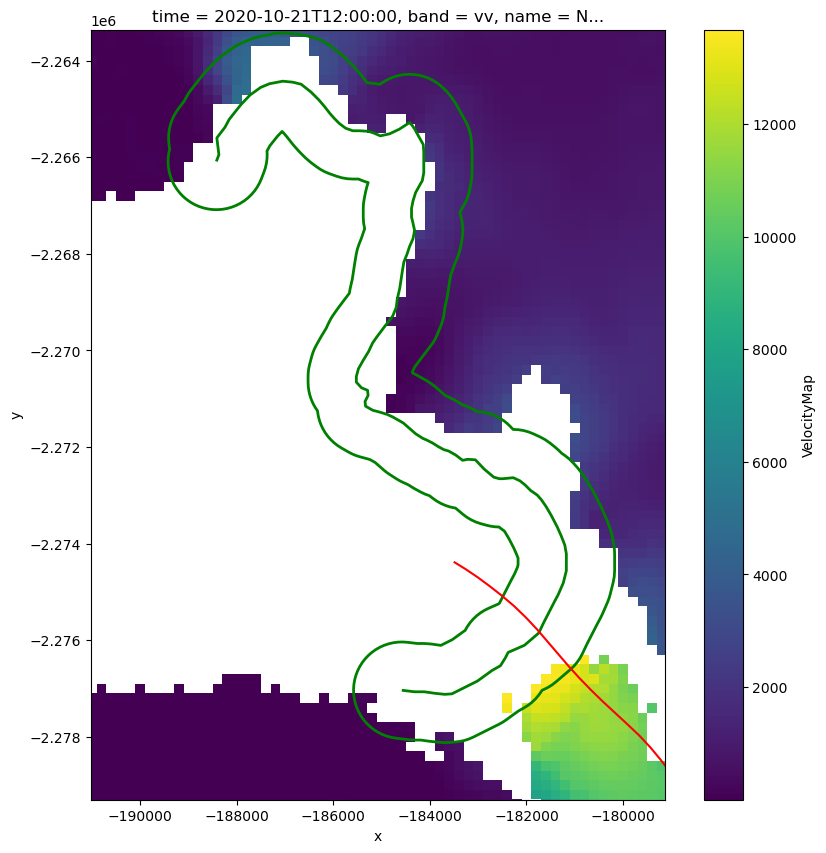

In [10]:
#visualisation w the buffer
sampletime = 300
buffer_dist = 1000  # meters

# pick nearest terminus to this velocity time
vel_time = velocity["time"].isel(time=sampletime).values
nearest_idx = (terminus["Date"] - vel_time).abs().idxmin()
term_one = terminus.loc[[nearest_idx]]
term_line = term_one.geometry.iloc[0]

# buffer polygon
term_buffer = term_line.buffer(buffer_dist)
term_buffer_gs = gpd.GeoSeries([term_buffer], crs=terminus.crs)

fig, ax = plt.subplots(figsize=(10, 10))

vel_slice.plot(ax=ax, x="x", y="y", add_colorbar=True)

# buffer
term_buffer_gs.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=2)

# terminus line + centreline
term_one.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=2)
gpd.GeoSeries([centreline_shape], crs=terminus.crs).plot(ax=ax, color="red", linewidth=1.5)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()


In [24]:
# xarray slice will only work if the cooridante is sorter the way the slice assumes, i.e., y is increasing from first to last 
def nearest_buffer(velocity, x0, y0, buffer = 1000):
    """nearest non-nan value to (x0,y0) within a buffer."""
    # subset window (handle y increasing/decreasing) - #xarray slicing depends on whether y coordinates increase or decrease
    y_increasing = float(velocity["y"][0]) < float(velocity["y"][-1])
    y_slice = slice(y0 - buffer, y0 + buffer) if y_increasing else slice(y0 + buffer, y0 - buffer)

#subset velocity into buffer window 
    subset_velocity = velocity.sel(
        x=slice(x0 - buffer, x0 + buffer),
        y=y_slice,
    )

    # if everything is NaN --> return NaN
    if int(subset_velocity.notnull().sum()) == 0:
        return np.nan

    # squared distance field (xarray broadcasts x and y across (y,x))
    distance = (subset_velocity["x"] - x0) ** 2 + (subset_velocity["y"] - y0) ** 2 #basically like the distance equation
    # ignore distances where velocity is NaN
    distance = distance.where(subset_velocity.notnull())

    # stack to 1D so we can pick a single closest element cleanly
    distances = distance.stack(pixel=("y", "x"))
    velocities = subset_velocity.stack(pixel=("y", "x"))

    # label of the minimum-distance element
    nearest_pixel= distances.idxmin("pixel")

    # return the velocity at that element
    return float(velocities.sel(pixel=nearest_pixel).values)


In [27]:
buffer_dist = 1000 

vel_nearest = []
matched_vel_time = []

for i in range(len(terminus)):
    pt = terminus["intersect_points"].iloc[i]

    # skip if no intersection point
    if (pt is None) or (hasattr(pt, "is_empty") and pt.is_empty):
        vel_nearest.append(np.nan)
        matched_vel_time.append(pd.NaT) #store not a time for the velocity 
        continue

    # terminus date
    t_term = pd.to_datetime(terminus["Date"].iloc[i])

    # nearest velocity time index
    vel_time_index= int(np.argmin(np.abs(vel_times - t_term)))
    matched_vel_time.append(vel_times[vel_time_index])

    # velocity slice at that nearest time
    vel_slice = vel_band.isel(time=vel_time_index)

    # nearest valid velocity within buffer around the point
    v = nearest_buffer(vel_slice, pt.x, pt.y, buffer=buffer_dist)
    vel_nearest.append(v)

terminus["vel_nearest_buffer"] = vel_nearest
terminus["matched_vel_time"] = matched_vel_time


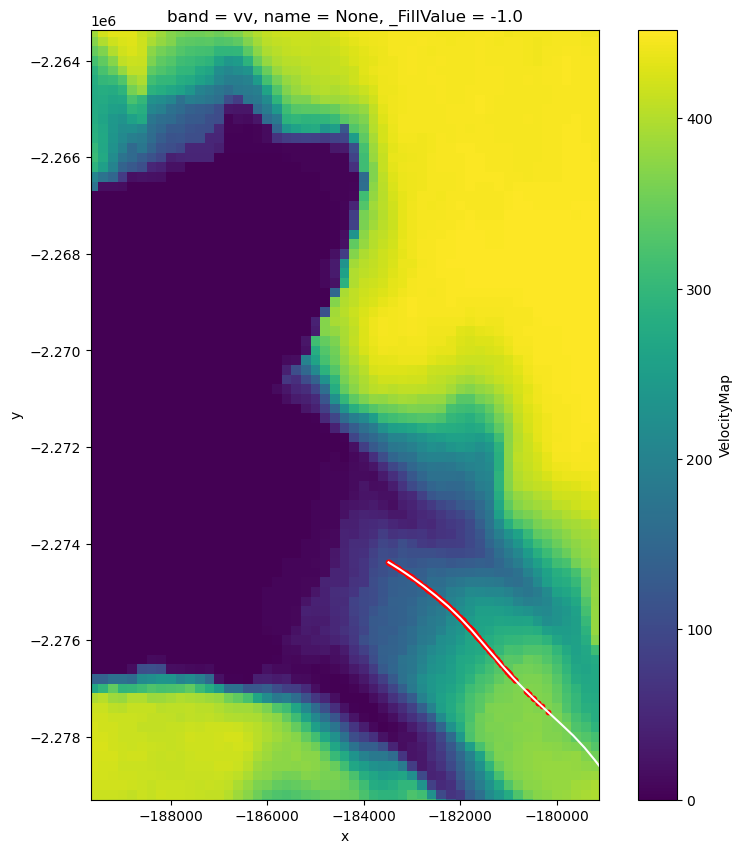

In [40]:
#intersect points 
sampletime = 113

vel_slice = vel_band.isel(time=sampletime)  
fig, ax = plt.subplots(figsize=(10, 10))

valid_count.plot(
    ax=ax,
    x="x",
    y="y",
    add_colorbar=True,
)

terminus.set_geometry("intersect_points").plot(
    ax=ax,
    color="red",
    markersize=10,
)

centreline_gs.plot(ax=ax, color="white", linewidth=1.5)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()

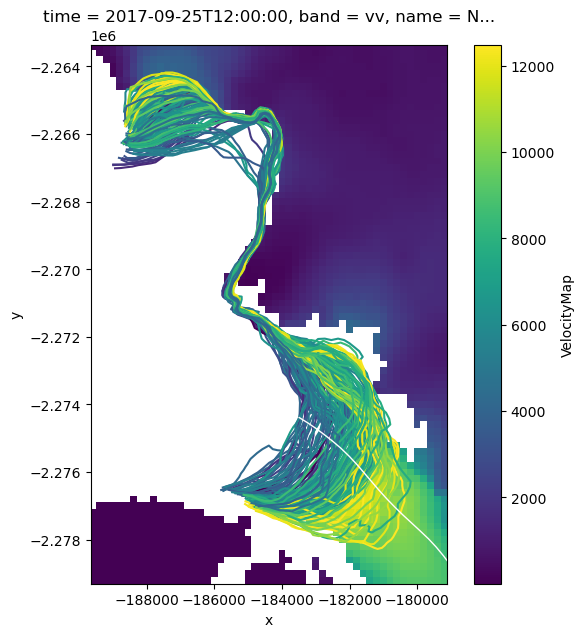

In [44]:
fig, ax = plt.subplots(figsize=(7, 7))

# velocity raster
vel_slice.plot(ax=ax, x="x", y="y", add_colorbar=True)

# plot sampled velocities as points
terminus.plot(
    ax=ax,
    column="vel_nearest_buffer",
    markersize=15,
)

centreline_gs.plot(ax=ax, color="white", linewidth=1)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()


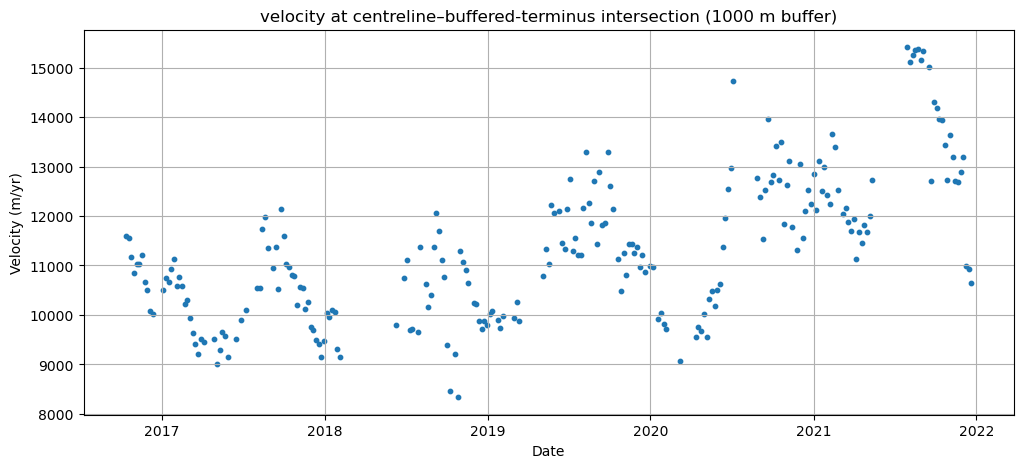

In [29]:
plt.figure(figsize=(12, 5))
plt.scatter(terminus["Date"], terminus["vel_nearest_buffer"], s=10)
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("velocity at centreline–buffered-terminus intersection (1000 m buffer)")
plt.grid(True)
plt.show()

In [30]:
centreline_maqit = pd.read_csv(centreline_maqit_path, skiprows=1)


centreline_maqit["Date"] = pd.to_datetime(
    dict(Year=centreline_maqit["Year"],
        Month=centreline_maqit["Month"],
        Day=centreline_maqit["Day"])
)

cl = centreline_maqit[[
    "Date",
    "Terminus Position on flowline",
    "Terminus change (m)"
]]

cl = cl.rename(columns = {
    "Terminus Position on flowline": "L", 
    "Terminus change (m)": "del_L"
})

cl

#merge to terminus set

terminus = terminus.merge(cl)
terminus = terminus.sort_values("Date").reset_index(drop=True)


In [31]:
#dt calc
terminus["dt_days"] = terminus["Date"].diff().dt.days
terminus["dt_years"] = terminus["dt_days"] / 365.25

#dt calc
terminus["dL"] = terminus["L"].diff()
terminus["dLdt"] = terminus["dL"] / terminus["dt_years"]

In [46]:
terminus["calving"] = terminus["vel_nearest_buffer"] - terminus["dLdt"]
terminus["calving_magnitude"] = terminus["calving"]/365.25

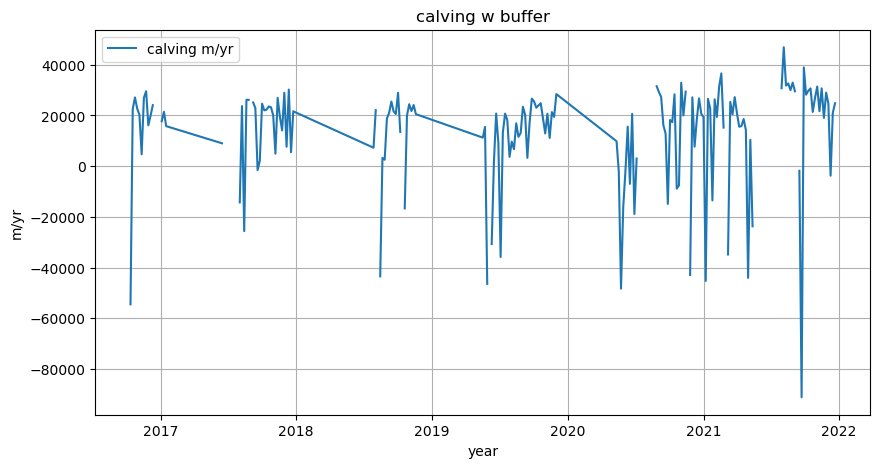

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(terminus["Date"], terminus["calving"],  label = "calving m/yr" )
plt.title("calving")
ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


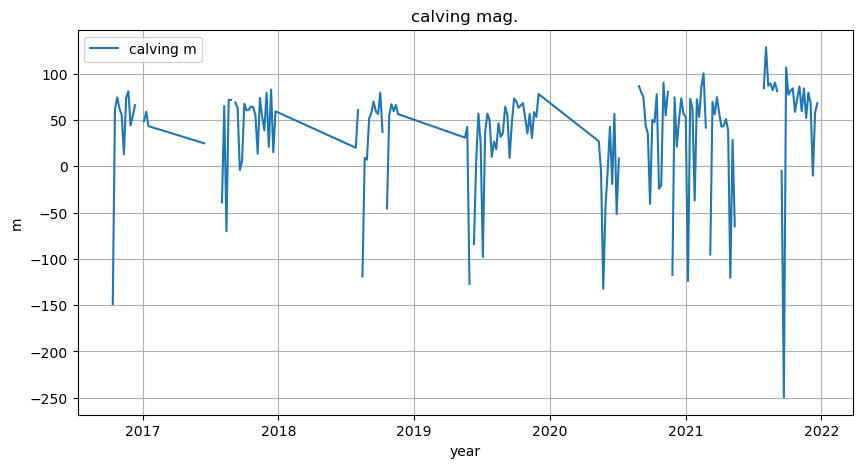

In [49]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(terminus["Date"], terminus["calving_magnitude"],  label = "calving m" )
plt.title("calving mag.")
ax.set_xlabel("year")
ax.set_ylabel("m")
ax.grid(True)
ax.legend()
plt.show()

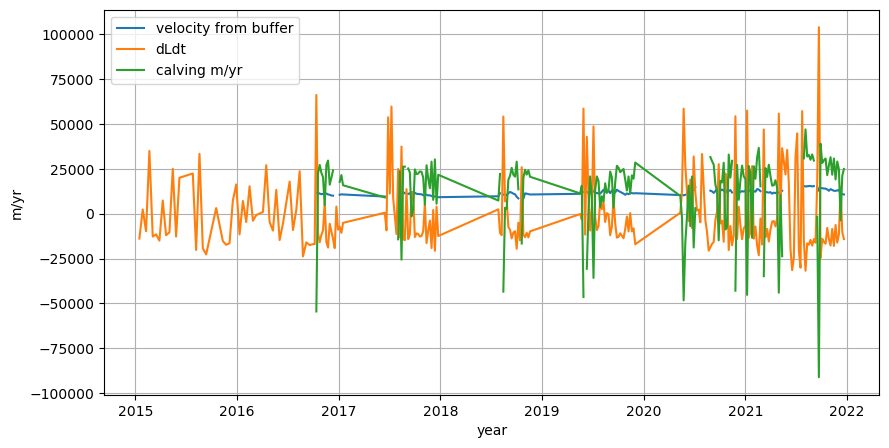

In [65]:

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(terminus["Date"], terminus["vel_nearest_buffer"], label = "velocity from buffer" )
ax.plot(terminus["Date"], terminus["dLdt"], label = "dLdt")
ax.plot(terminus["Date"], terminus["calving"],  label = "calving m/yr" )

ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


In [22]:
#this is was original attempt using u = 1500 m/yr

In [24]:
terminus

,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry,intersect_points,velocity_intersection,buffer,buffer_intersect_points,velocity_buffer_pt,L,del_L,dt_days,dt_years,dL,dLdt,calving
0,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399....",POINT (-182302.33390831872 -2275255.0299488134),NaN,"POLYGON ((-189306.988 -2265055.099, -189263.69...",POINT (-182388.11269200183 -2275182.1060847165),NaN,1492.80,NaN,NaN,NaN,NaN,NaN,NaN
1,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629....",POINT (-182654.5811722098 -2274965.15839306),NaN,"POLYGON ((-189629.49 -2264978.882, -189624.272...",POINT (-182480.64491905228 -2275103.4408570193),NaN,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,NaN
2,SEN1_NSIDC_0723_V2_20150125_20150205,S1A_090_004362,2015-01-27,1,3,"LINESTRING (-186068.771 -2276605.242, -185814....",POINT (-182594.66389060495 -2275012.2059813403),NaN,"POLYGON ((-188545.249 -2264094.934, -188509.41...",POINT (-182603.700575338 -2275005.110295232),NaN,1112.70,76.181,12.0,0.032854,76.20,2319.337500,NaN
3,SEN1_NSIDC_0723_V2_20150206_20150217,S1A_090_004537,2015-02-08,0,3,"LINESTRING (-184745.971 -2277111.477, -184132....",POINT (-182850.18781654522 -2274815.9306988167),NaN,"POLYGON ((-187187.876 -2265453.1, -187199.666 ...",POINT (-182692.5444580805 -2274935.3492796356),NaN,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,NaN
4,SEN1_NSIDC_0723_V4_20150218_20150301,S1A_090_004712,2015-02-20,0,3,"LINESTRING (-185068.764 -2276846.893, -184507....",POINT (-181981.37287173132 -2275562.417235696),NaN,"POLYGON ((-189440.183 -2265065.256, -189427.36...",POINT (-182289.13461320315 -2275266.251180473),NaN,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,SEN1_NSIDC_0723_V4_20211125_20211130,S1A_090_040762,2021-11-27,0,3,"LINESTRING (-185111.097 -2276688.143, -184878....",POINT (-182377.55969028606 -2275191.0775999315),NaN,"POLYGON ((-188264.545 -2265390.539, -188217.16...",POINT (-182376.54909323467 -2275191.9367476003),NaN,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,NaN
242,SEN1_NSIDC_0723_V4_20211201_20211206,S1B_090_029866,2021-12-03,1,3,"LINESTRING (-185164.014 -2276666.976, -184867....",POINT (-182522.16672362867 -2275069.1314087305),NaN,"POLYGON ((-186269.536 -2271567.172, -186270.88...",POINT (-182528.26744955353 -2275064.341063878),NaN,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,NaN
243,SEN1_NSIDC_0723_V4_20211207_20211212,S1A_090_040937,2021-12-09,1,3,"LINESTRING (-184931.18 -2276910.393, -184380.8...",POINT (-182337.44590745497 -2275225.1798793296),NaN,"POLYGON ((-188690.355 -2265152.386, -188460.66...",POINT (-182424.5919654968 -2275151.0936423796),NaN,1446.70,241.830,6.0,0.016427,241.80,14719.575000,NaN
244,SEN1_NSIDC_0723_V4_20211213_20211218,S1B_090_030041,2021-12-15,1,3,"LINESTRING (-184793.596 -2276973.893, -184497....",POINT (-182464.42914589713 -2275117.2265134137),NaN,"POLYGON ((-186345.708 -2271375.76, -186360.341...",POINT (-182499.22022296957 -2275087.649272198),NaN,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,NaN


In [23]:
#change to date time (this is a thing)
terminus["Date"] = pd.to_datetime(
    dict(year = terminus["Year"],
        month = terminus["Month"],
        day = terminus["Day"])
)

terminus = terminus.rename(columns = {
    "Terminus Position on flowline": "L",
    "Terminus change (m)": "del_L"
})

#for simplicity i just want these (for now, tbd)
terminus_columns = ["Date", "L", "del_L"]
terminus = terminus[terminus_columns].sort_values("Date").reset_index(drop= True)


KeyError: 'Year'

In [ ]:
#terminus df 
df = terminus.copy().sort_values("Date").reset_index(drop=True)

#dt calc
df["dt_days"] = df["Date"].diff().dt.days
df["dt_years"] = df["dt_days"] / 365.25

#dt calc
df["dL"] = df["L"].diff()
df["dLdt_per_year"] = df["dL"] / df["dt_years"]

df[["Date", "L", "dt_days", "dL", "dLdt_per_year"]].head(10)

#dLdt = dL ( 6 days) - terminus change between data / dt (per year)



,Date,L,dt_days,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN
1,2015-01-15,1036.50,12.0,-456.30,-13888.631250
2,2015-01-27,1112.70,12.0,76.20,2319.337500
3,2015-02-08,790.49,12.0,-322.21,-9807.266875
4,2015-02-20,1937.40,12.0,1146.91,34909.073125
5,2015-03-04,1518.00,12.0,-419.40,-12765.487500
6,2015-03-16,1139.70,12.0,-378.30,-11514.506250
7,2015-03-28,645.19,12.0,-494.51,-15051.648125
8,2015-04-09,884.89,12.0,239.70,7295.868750
9,2015-04-21,489.40,12.0,-395.49,-12037.726875


In [ ]:
#so w my velocity i should pick a point on the terminus right 
# - probably where it intersects the centreline

centreline.length

0    564300.353452
dtype: float64

In [ ]:
vv = velocity["VelocityMap"].sel(band="vv")
print("min, max:", float(vv.min()), float(vv.max()))

min, max: 0.006762796081602573 16439.25


In [ ]:
xmin, xmax = float(vv.x.min()), float(vv.x.max())
ymin, ymax = float(vv.y.min()), float(vv.y.max())
print(xmin, xmax, ymin, ymax)

-194000.0 -170000.0 -2288000.0 -2264000.0


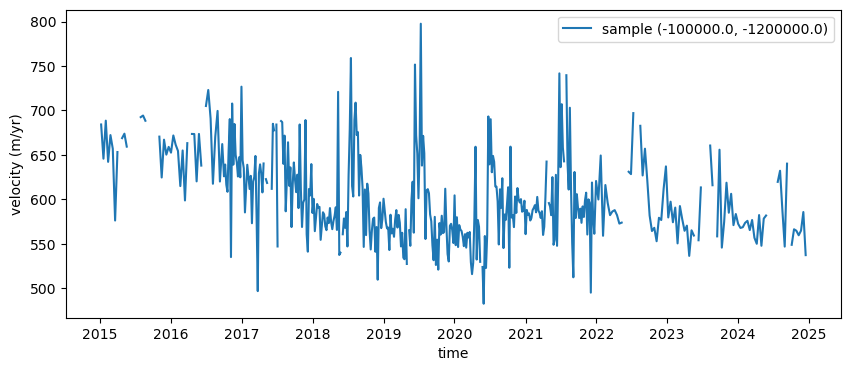

In [ ]:
x0 = -100000.0
y0 = -1200000.0

label = 'sample'

vv_band = velocity["VelocityMap"].sel(band='vv')

vel_sample_pt = vv_band.sel(x=x0, y=y0, method='nearest')
df_selected_point = vel_sample_pt.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_selected_point['time'], df_selected_point['VelocityMap'], label=f'{label} ({x0}, {y0})')
plt.xlabel('time')
plt.ylabel('velocity (m/yr)')
plt.legend()
plt.show()

#should clean this? claire has a notebook on this 
#should also find a way to pick a point near the terminsu 
# no needto interpooalte

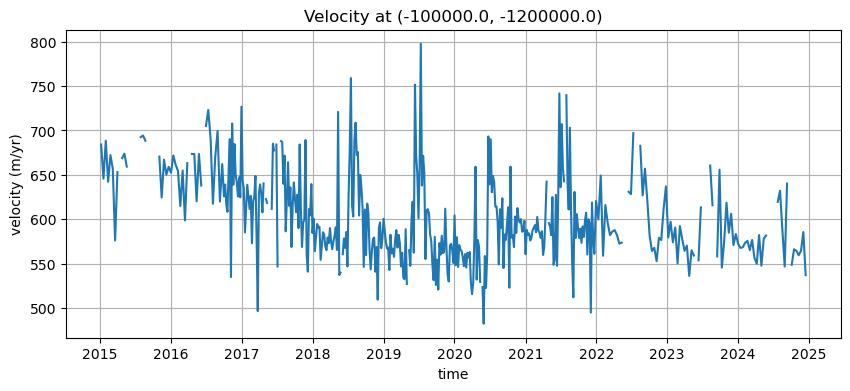

In [ ]:

#random upstream point 
sample1 = vv.sel(x=-170000, y=-2200000, method="nearest")  # DataArray with time dim
df_sample = sample1.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_sample["time"], df_sample["VelocityMap"])
plt.xlabel("time")
plt.ylabel("velocity (m/yr)")
plt.title(f"Velocity at ({x0}, {y0})")
plt.grid()
plt.show()



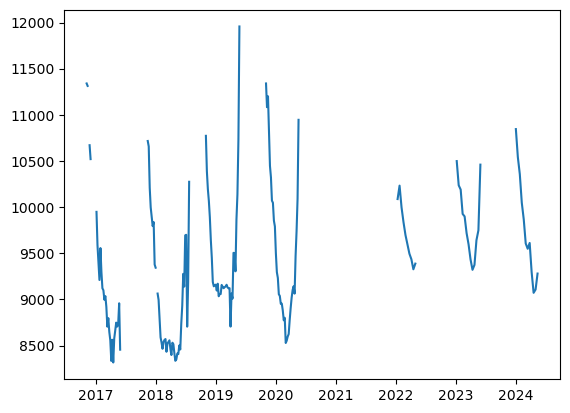

In [ ]:
#at date = 1
x_pt = df.loc[0, "x"]
y_pt = df.loc[0, "y"]

vel_pt = vv.sel(x=x_pt, y=y_pt, method="nearest")
df_vel = vel_pt.to_dataframe().reset_index()
plt.plot(df_vel["time"], df_vel["VelocityMap"])

In [ ]:
u_vals = []       # velocity at intersection (m/yr)

for _, row in df.iterrows():
    x = row["x"]
    y = row["y"]
    t = row["Date"]

    if pd.isna(x) or pd.isna(y) or pd.isna(t):
        u_vals.append(np.nan)
        continue

    v_intersect = vv.sel(time=t, x=x, y=y, method="nearest").values

    if np.isnan(v_intersect):
        u_vals.append(np.nan)
    else:
        u_vals.append(float(v_intersect))


df["u_per_yr"] = u_vals

In [ ]:
# assuming a veloicty of 1500 m/a to begin the calving series

u_constant = 1500.0 #unit is m /year 

df["u_per_year"] = u_constant


,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving,vel_date,vel_dt_days
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN,2015-01-06 12:00:00,3.5
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250,2015-01-18 12:00:00,3.5
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500,2015-01-30 12:00:00,3.5
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875,2015-02-11 12:00:00,3.5
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125,2015-02-23 12:00:00,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500,2021-11-27 12:00:00,0.5
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000,2021-12-03 12:00:00,0.5
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000,2021-12-09 12:00:00,0.5
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000,2021-12-15 12:00:00,0.5


In [ ]:
df["calving"] = df["u_per_year"] - df["dLdt_per_year"]

#calving unit is m /yr
# calving rate > 0 : terminus advance  (due to velocity)
# calving rate < 0 : terminus retreat (due to calving)

In [ ]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000


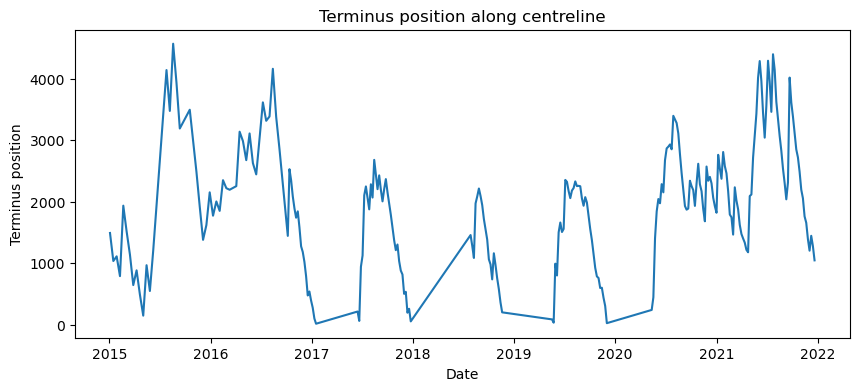

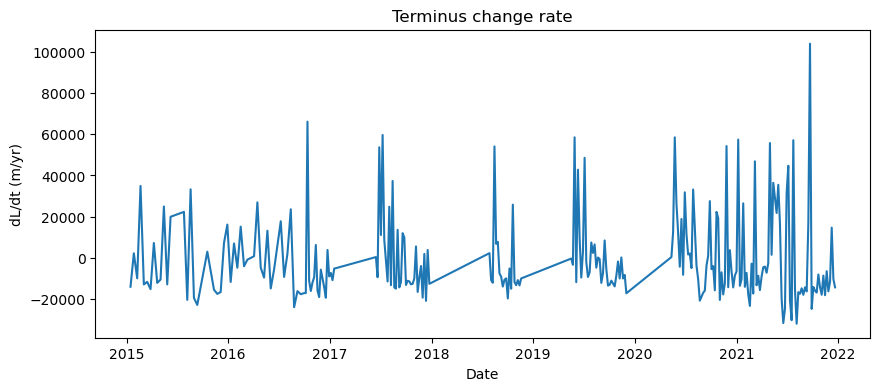

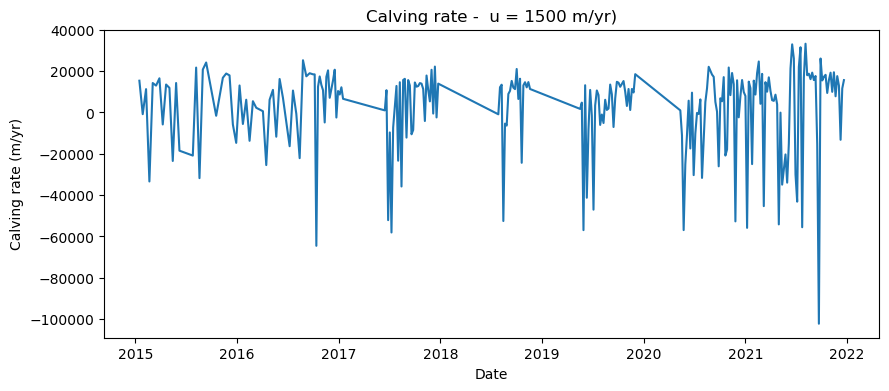

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["L"])
plt.xlabel("Date")
plt.ylabel("Terminus position")
plt.title("Terminus position along centreline")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["dLdt_per_year"])
plt.xlabel("Date")
plt.ylabel("dL/dt (m/yr)")
plt.title("Terminus change rate")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["calving"])
plt.xlabel("Date")
plt.ylabel("Calving rate (m/yr)")
plt.title("Calving rate -  u = 1500 m/yr)")
plt.show()